# Exercise: Moveout of earthquakes

### Import modules

Here we provide you with the most important modules and functions already. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 
%matplotlib widget

In [2]:
import pickle 
import os

import pandas as pd
import numpy as np

from obspy import read
from obspy.taup import TauPyModel
from obspy.geodetics import gps2dist_azimuth, locations2degrees

import matplotlib.pyplot as plt

def calculate_distance(lon1, lat1, lon2, lat2):
    distance, _, _ = gps2dist_azimuth(lat1, lon1, lat2, lon2)
    return distance / 1000  # Convert to kilometers

def calculate_distance_degrees(lon1, lat1, lon2, lat2):
    dist_deg = locations2degrees(lat1, lon1, lat2, lon2)
    return dist_deg

def get_phases_and_arrivals(lon1, lat1, lon2, lat2, depth, bg_model="ak135", phase_list=["P", "S"]):
    dist = calculate_distance_degrees(lon1, lat1, lon2, lat2)
    model = TauPyModel(model=bg_model)

    travel_times = model.get_travel_times(
        source_depth_in_km=depth, 
        distance_in_degree=dist,
        # phase_list=phase_list,
    )

    # print(travel_times)
    arrival = [(tt.time, tt.name) for tt in travel_times]
    # print(lon1, lat1, lon2, lat2, depth, dist, arrival)
    try:
        arrivals, phases = zip(*arrival)
    except ValueError:
        arrivals, phases = [], []

    return phases, arrivals

### Download data using [ObspyDMT](https://github.com/kasra-hosseini/obspyDMT?tab=readme-ov-file#synthetic-seismograms)

Here we are using a command line in our notebook. 

In [ ]:
! obspyDMT --datapath /home/obsworkshop/Desktop/Data/QC/data_fiji_island --min_mag 6.8 --min_date 2014-07-21 --max_date 2014-07-22 --event_catalog NEIC_USGS --data_source IRIS --min_azi 50 --max_azi 55 --min_epi 94 --max_epi 100 --cha BHZ --instrument_correction
# ! obspyDMT --datapath /home/obsworkshop/Desktop/Data/QC/data_rhum_rum_iran --min_mag 6.8 --min_date 2013-04-16 --max_date 2013-04-17 --event_catalog NEIC_USGS --data_source RESIF --net YV --cha BHZ --instrument_correction


Use obspyDMT's internal function to plot the moveout. (The figure is in the data_fiji_island folder.)

In [ ]:
! obspyDMT --datapath /home/obsworkshop/Desktop/Data/QC/data_fiji_island --local --plot_waveform --plot_dir processed --plot_save="data_fiji_island/plot_waveform_moveout.png"
# ! obspyDMT --datapath /home/obsworkshop/Desktop/Data/QC/data_fiji_island --local --plot_waveform --plot_dir processed --plot_save="data_rhum_rum_iran/plot_waveform_moveout.png"



## Exercise 
Write your own moveout function only using the information from the downloaded event (and make it nicer than the obspyDMT function).

### 1. Read in the event information

Here we are reading a pickle file -- which might not be that common but is a useful format to know. \
Define the path and then try "pickle.load" to read them into an event_list.

In [ ]:
# CODE HERE.

### 2. Read in the station information 

Here we can red the file into a pandas dataframe.

First define the station info file, then the names of the individual columns in that file. The column information should normally be stored somewhere in the files (some of them are more or less obvious). We have left the definitions in.

Afterwards, use both to read the info (e.g., using panda: "pd.read_csv").

A few extra suggestions:
- Clean up the location column by replacing NaN with an empty string (e.g., using "fillna") -- otherwise there will be problems later with the plotting.
- Convert location codes to strings (e.g., 0.0 -> '00', 10.0 -> '10'), because that is how they are stored in the data (Python thinks they are a number and, therefore, changes it.)

In [ ]:
# Convert numeric location codes to strings (e.g., 0.0 -> '00', 10.0 -> '10')
def format_location(loc):
    if pd.isna(loc) or loc == '':
        return ''
    elif isinstance(loc, (int, float)):
        return f"{int(loc):02d}"  # Convert to zero-padded string
    else:
        return str(loc)
    
# First define the station info file.
station_info = XXX

# Define proper column names based on the data structure.
column_names = ['network', 'station', 'location', 'channel', 'station_lat', 'station_lon', 
                'station_elev', 'station_depth', 'data_source', 'event_id', 'event_lat', 
                'event_lon', 'event_depth', 'magnitude', 'unknown1', 'unknown2', 'unknown3', 'extra']

# REST OF THE CODE HERE.

### 3. Calculate the distance from earthquake to station

You can use the definitions given in the beginning to do this.

Since you already have a pandas dataframe with the station_info the easiest would be to add it to the dataframe. \
Adding to the dataframe can be done using a "lambda" function row by row:

dataframe["distance_km"] = dataframe.apply(lambda row: whatever_you_want_to_do(arguments_you_want_to_use), axis=1)

The "axis=1" is used to apply the function to each row (aka station) in the dataframe.

In [3]:
# Example for a lambda function:

x = lambda a: a + 10
print(x(5))
print(x(13))

15
23


In [ ]:
# CODE HERE.

### 4. Load the waveforms and make a simple plot

- For better visualisation, try to sort stations by distance using the information calculated in the previous step.
- Load the mseed files inside the loop to plot them station by station.
- The important information to use are "data" and "times()". Note that "times()" is a method, not an attribute, and needs brackets.
- Normalise the trace amplitude.
- Offset the traces by distance, otherwise they will end up on top of each other.

In [ ]:
plt.figure(figsize=(12, 8))

# Sort stations by distance for better moveout visualization
df_sorted = df_station.sort_values("distance_deg")

for index, row in df_station.iterrows():
    # It is good practise to include try and except statements, so that the script runs
    # even in instances where something goes wrong along the way.
    try:
        # Construct proper filename - handle empty location codes
        if row["location"] == "":
            filename = f"{row['network']}.{row['station']}..{row['channel']}"
        else:
            filename = (
                f"{row['network']}.{row['station']}.{row['location']}.{row['channel']}"
            )

        # CODE HERE.

    except Exception as e:
        print(f"Could not load data for {row['station']}: {e}")
        continue

# Maybe add some extra details to the plot (e.g., title, axes labels,...).


### 5. Add a filter to your plot 

Copy the code from the previous step.

Now add the filter, but don't forget to detrend, demean and taper before filtering!

In [ ]:
# CODE HERE.

### 6. Add with TauP the theoretical arrival times for P and S to your plot

#### General commands

Feel free to play around with those to see what happens. There are also more parameters to include than the ones shown here.

There were rays for all but the following epicentral distances:
 [0.0, 360.0]


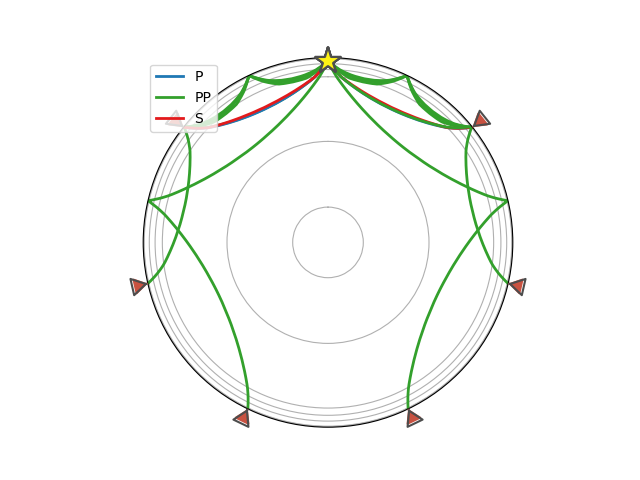

In [4]:
from obspy.taup import plot_ray_paths
import matplotlib.pyplot as plt
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax = plot_ray_paths(source_depth=100, npoints=8, ax=ax, fig=fig, verbose=True,
                    phase_list=['P', 'S', 'PP'], legend=True)


In [5]:
from obspy.taup import TauPyModel

model = TauPyModel(model="iasp91")
arrivals = model.get_travel_times(source_depth_in_km=55, distance_in_degree=67)
print(arrivals)

28 arrivals
	P phase arrival at 647.041 seconds
	pP phase arrival at 662.233 seconds
	sP phase arrival at 668.704 seconds
	PcP phase arrival at 674.865 seconds
	PP phase arrival at 794.992 seconds
	PKiKP phase arrival at 1034.098 seconds
	pPKiKP phase arrival at 1050.528 seconds
	sPKiKP phase arrival at 1056.721 seconds
	S phase arrival at 1176.948 seconds
	pS phase arrival at 1195.508 seconds
	SP phase arrival at 1196.830 seconds
	sS phase arrival at 1203.129 seconds
	PS phase arrival at 1205.421 seconds
	SKS phase arrival at 1239.090 seconds
	SKKS phase arrival at 1239.109 seconds
	ScS phase arrival at 1239.512 seconds
	SKiKP phase arrival at 1242.388 seconds
	pSKS phase arrival at 1260.314 seconds
	sSKS phase arrival at 1266.921 seconds
	SS phase arrival at 1437.427 seconds
	PKIKKIKP phase arrival at 1855.271 seconds
	SKIKKIKP phase arrival at 2063.564 seconds
	PKIKKIKS phase arrival at 2069.756 seconds
	SKIKKIKS phase arrival at 2277.857 seconds
	PKIKPPKIKP phase arrival at 2353.93

In [6]:
arrivals = model.get_travel_times(
    source_depth_in_km=100, distance_in_degree=45, phase_list=["P", "S"]
)
print(arrivals)

2 arrivals
	P phase arrival at 485.210 seconds
	S phase arrival at 876.834 seconds


#### Plot phases and arrivals in the moveout plot

This can be done similarly to step 3. Again, there is a pre-defined definition in the beginning that can be used.

In [ ]:
# CODE HERE.

Now use the same plotting script from before and add the phase arrivals. This can be done individually for every station after plotting the waveforms, using the "scatter".

In [ ]:
# CODE HERE.

### 7. New dataset! 
Download an event from the RHUM-RUM experiment. Tip: use Wilber3 to scope for events during the deployment time of RHUM-RUM.  